
Important Libraries

In [2]:
# Importerar nödvändiga Libraries

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

# Importing Deep Learning Libraries ipykernel

from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop


Displaying Images

In [16]:

folder_path = 'D:/DataSets/images/images/'
picture_size = 48

<function matplotlib.pyplot.show(close=None, block=None)>

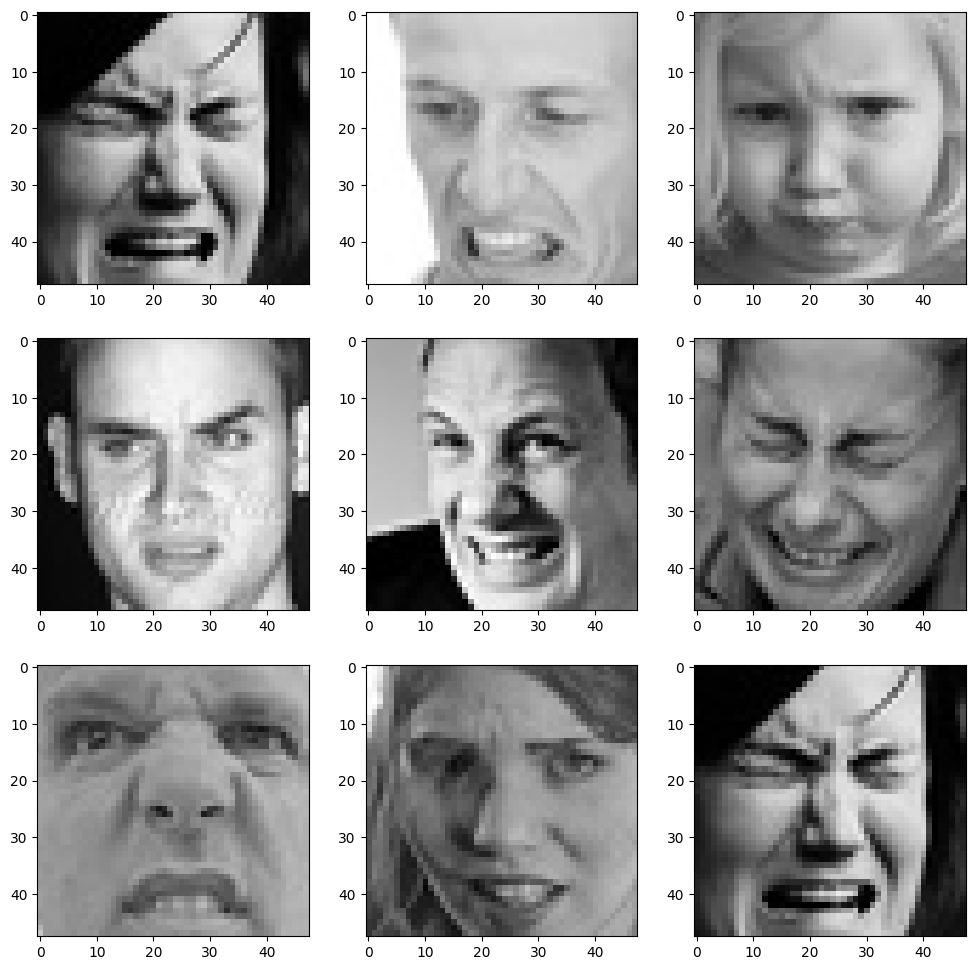

In [17]:
### Visualiserar exempelbilder för att kontrollera att bilderna laddas in korrekt och ser ut som förväntat


expression = 'disgust'

plt.figure(figsize=(12, 12))
for i in range(1, 10, 1):
  plt.subplot(3, 3, i)
  img = load_img(folder_path+'train/'+expression+'/'+
                 os.listdir(folder_path + 'train/' + expression)[i], target_size=(picture_size, picture_size))
  plt.imshow(img)
plt.show

In [18]:
# Förbereder tränings- och valideringsdata för att användas i modellen

batch_size = 128

datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(folder_path+'train',
                                              target_size = (picture_size, picture_size),
                                              color_mode ='grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)

test_set = datagen_val.flow_from_directory(folder_path+'validation',
                                              target_size = (picture_size, picture_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = False)


Found 25616 images belonging to 6 classes.
Found 6269 images belonging to 6 classes.


In [19]:
train_set[0]

(array([[[[  2.],
          [  4.],
          [  5.],
          ...,
          [ 64.],
          [ 43.],
          [ 18.]],
 
         [[  7.],
          [  8.],
          [  6.],
          ...,
          [ 60.],
          [ 35.],
          [ 11.]],
 
         [[  9.],
          [  7.],
          [  5.],
          ...,
          [ 52.],
          [ 27.],
          [  8.]],
 
         ...,
 
         [[  4.],
          [  6.],
          [ 10.],
          ...,
          [ 59.],
          [ 11.],
          [ 29.]],
 
         [[  5.],
          [  5.],
          [ 10.],
          ...,
          [ 59.],
          [ 45.],
          [ 47.]],
 
         [[  4.],
          [  4.],
          [ 10.],
          ...,
          [ 49.],
          [ 55.],
          [ 64.]]],
 
 
        [[[254.],
          [255.],
          [254.],
          ...,
          [253.],
          [255.],
          [255.]],
 
         [[255.],
          [255.],
          [255.],
          ...,
          [254.],
          [2

Model Building

In [20]:
# Skapar modellen med olika lager för att extrahera funktioner och klassificera bilder i 7 kategorier

no_of_classes = 6

model = Sequential()

# Första konvolutionslagret för att extrahera lågnivåfunktioner
model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Andra konvolutionslagret för att extrahera mer komplexa funktioner
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Tredje konvolutionslagret för att extrahera ännu mer komplexa funktioner
model.add(Conv2D(512, (3,3), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Fjärde konvolutionslagret för att ytterligare förfina funktionerna
model.add(Conv2D(128, (5,5), padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Flatten lagret för att konvertera 2D-data till 1D-data
model.add(Flatten())

# Första fullt anslutna lagret för att kombinera extraherade funktioner
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Andra fullt anslutna lagret för att ytterligare kombinera funktioner
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Utgångslager med softmax-aktivering för att klassificera i 6 kategorier
model.add(Dense(no_of_classes, activation= 'softmax'))

# Kompilering av modellen med Adam-optimizer och kategorisk korsentropi som förlustfunktion
opt = Adam(learning_rate = 0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

Fitting the model with Training and Validation Data

In [21]:
# Sparar modellen så att den kan användas senare, samt tillämpar olika regulariseringsmetoder för att förbättra modellen

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Checkpoint för att spara den bästa modellen baserat på valideringsnoggrannhet
checkpoint = ModelCheckpoint("./face.tf", monitor="val_accuracy", verbose=1, save_best_only=True, mode='max')

# Early stopping för att avbryta träningen när noggrannheten slutar förbättras för att undvika överträning
early_stopping = EarlyStopping(monitor='accuracy',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

# Reduce learning rate on plateau för att minska inlärningshastigheten när noggrannheten slutar förbättras
reduce_learningrate = ReduceLROnPlateau(monitor='accuracy',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

epochs = 48

In [22]:
# Tränar modellen med träningsdata och validerar med valideringsdata
# Använder callbacks för att spara bästa modell, avbryta vid överträning och justera inlärningshastigheten

history = model.fit(          
    train_set,
    steps_per_epoch= train_set.n//train_set.batch_size,
    epochs=epochs, 
    validation_data = test_set,
    validation_steps=  test_set.n//test_set.batch_size,
    callbacks=callbacks_list
    )

Epoch 1/48
200/200 [==============================] - ETA: 0s - loss: 2.0001 - accuracy: 0.2275
Epoch 1: val_accuracy improved from -inf to 0.33643, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 539s 3s/step - loss: 2.0001 - accuracy: 0.2275 - val_loss: 1.6037 - val_accuracy: 0.3364 - lr: 1.0000e-04
Epoch 2/48
200/200 [==============================] - ETA: 0s - loss: 1.7585 - accuracy: 0.2903
Epoch 2: val_accuracy improved from 0.33643 to 0.35791, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 353s 2s/step - loss: 1.7585 - accuracy: 0.2903 - val_loss: 1.5620 - val_accuracy: 0.3579 - lr: 1.0000e-04
Epoch 3/48
200/200 [==============================] - ETA: 0s - loss: 1.6766 - accuracy: 0.3262
Epoch 3: val_accuracy improved from 0.35791 to 0.36003, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 374s 2s/step - loss: 1.6766 - accuracy: 0.3262 - val_loss: 1.5716 - val_accuracy: 0.3600 - lr: 1.0000e-04
Epoch 4/48
200/200 [==============================] - ETA: 0s - loss: 1.6084 - accuracy: 0.3540
Epoch 4: val_accuracy improved from 0.36003 to 0.40332, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 380s 2s/step - loss: 1.6084 - accuracy: 0.3540 - val_loss: 1.5045 - val_accuracy: 0.4033 - lr: 1.0000e-04
Epoch 5/48
200/200 [==============================] - ETA: 0s - loss: 1.5448 - accuracy: 0.3790
Epoch 5: val_accuracy improved from 0.40332 to 0.42432, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 377s 2s/step - loss: 1.5448 - accuracy: 0.3790 - val_loss: 1.4347 - val_accuracy: 0.4243 - lr: 1.0000e-04
Epoch 6/48
200/200 [==============================] - ETA: 0s - loss: 1.4958 - accuracy: 0.3972
Epoch 6: val_accuracy improved from 0.42432 to 0.43652, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 377s 2s/step - loss: 1.4958 - accuracy: 0.3972 - val_loss: 1.4055 - val_accuracy: 0.4365 - lr: 1.0000e-04
Epoch 7/48
200/200 [==============================] - ETA: 0s - loss: 1.4520 - accuracy: 0.4168
Epoch 7: val_accuracy improved from 0.43652 to 0.45085, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 388s 2s/step - loss: 1.4520 - accuracy: 0.4168 - val_loss: 1.3750 - val_accuracy: 0.4508 - lr: 1.0000e-04
Epoch 8/48
200/200 [==============================] - ETA: 0s - loss: 1.4152 - accuracy: 0.4335
Epoch 8: val_accuracy improved from 0.45085 to 0.46810, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 362s 2s/step - loss: 1.4152 - accuracy: 0.4335 - val_loss: 1.3218 - val_accuracy: 0.4681 - lr: 1.0000e-04
Epoch 9/48
200/200 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.4416
Epoch 9: val_accuracy improved from 0.46810 to 0.46973, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 369s 2s/step - loss: 1.3890 - accuracy: 0.4416 - val_loss: 1.3286 - val_accuracy: 0.4697 - lr: 1.0000e-04
Epoch 10/48
200/200 [==============================] - ETA: 0s - loss: 1.3551 - accuracy: 0.4564
Epoch 10: val_accuracy improved from 0.46973 to 0.49251, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 368s 2s/step - loss: 1.3551 - accuracy: 0.4564 - val_loss: 1.2845 - val_accuracy: 0.4925 - lr: 1.0000e-04
Epoch 11/48
200/200 [==============================] - ETA: 0s - loss: 1.3288 - accuracy: 0.4695
Epoch 11: val_accuracy improved from 0.49251 to 0.49365, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 396s 2s/step - loss: 1.3288 - accuracy: 0.4695 - val_loss: 1.2591 - val_accuracy: 0.4937 - lr: 1.0000e-04
Epoch 12/48
200/200 [==============================] - ETA: 0s - loss: 1.2987 - accuracy: 0.4838
Epoch 12: val_accuracy improved from 0.49365 to 0.52148, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 372s 2s/step - loss: 1.2987 - accuracy: 0.4838 - val_loss: 1.2116 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 13/48
200/200 [==============================] - ETA: 0s - loss: 1.2759 - accuracy: 0.4940
Epoch 13: val_accuracy did not improve from 0.52148
200/200 [==============================] - 361s 2s/step - loss: 1.2759 - accuracy: 0.4940 - val_loss: 1.2168 - val_accuracy: 0.5171 - lr: 1.0000e-04
Epoch 14/48
200/200 [==============================] - ETA: 0s - loss: 1.2545 - accuracy: 0.5051
Epoch 14: val_accuracy did not improve from 0.52148
200/200 [==============================] - 388s 2s/step - loss: 1.2545 - accuracy: 0.5051 - val_loss: 1.2597 - val_accuracy: 0.5013 - lr: 1.0000e-04
Epoch 15/48
200/200 [==============================] - ETA: 0s - loss: 1.2332 - accuracy: 0.5101
Epoch 15: val_accuracy improved from 0.52148 to 0.54281, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 399s 2s/step - loss: 1.2332 - accuracy: 0.5101 - val_loss: 1.1752 - val_accuracy: 0.5428 - lr: 1.0000e-04
Epoch 16/48
200/200 [==============================] - ETA: 0s - loss: 1.2191 - accuracy: 0.5184
Epoch 16: val_accuracy did not improve from 0.54281
200/200 [==============================] - 407s 2s/step - loss: 1.2191 - accuracy: 0.5184 - val_loss: 1.1617 - val_accuracy: 0.5384 - lr: 1.0000e-04
Epoch 17/48
200/200 [==============================] - ETA: 0s - loss: 1.2013 - accuracy: 0.5289
Epoch 17: val_accuracy improved from 0.54281 to 0.55941, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 425s 2s/step - loss: 1.2013 - accuracy: 0.5289 - val_loss: 1.1294 - val_accuracy: 0.5594 - lr: 1.0000e-04
Epoch 18/48
200/200 [==============================] - ETA: 0s - loss: 1.1856 - accuracy: 0.5330
Epoch 18: val_accuracy improved from 0.55941 to 0.56038, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 412s 2s/step - loss: 1.1856 - accuracy: 0.5330 - val_loss: 1.1402 - val_accuracy: 0.5604 - lr: 1.0000e-04
Epoch 19/48
200/200 [==============================] - ETA: 0s - loss: 1.1571 - accuracy: 0.5437
Epoch 19: val_accuracy did not improve from 0.56038
200/200 [==============================] - 372s 2s/step - loss: 1.1571 - accuracy: 0.5437 - val_loss: 1.1242 - val_accuracy: 0.5532 - lr: 1.0000e-04
Epoch 20/48
200/200 [==============================] - ETA: 0s - loss: 1.1450 - accuracy: 0.5496
Epoch 20: val_accuracy improved from 0.56038 to 0.57243, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 378s 2s/step - loss: 1.1450 - accuracy: 0.5496 - val_loss: 1.0982 - val_accuracy: 0.5724 - lr: 1.0000e-04
Epoch 21/48
200/200 [==============================] - ETA: 0s - loss: 1.1314 - accuracy: 0.5534
Epoch 21: val_accuracy did not improve from 0.57243
200/200 [==============================] - 377s 2s/step - loss: 1.1314 - accuracy: 0.5534 - val_loss: 1.1234 - val_accuracy: 0.5684 - lr: 1.0000e-04
Epoch 22/48
200/200 [==============================] - ETA: 0s - loss: 1.1148 - accuracy: 0.5626
Epoch 22: val_accuracy improved from 0.57243 to 0.58105, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 384s 2s/step - loss: 1.1148 - accuracy: 0.5626 - val_loss: 1.0857 - val_accuracy: 0.5811 - lr: 1.0000e-04
Epoch 23/48
200/200 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.5689
Epoch 23: val_accuracy improved from 0.58105 to 0.58366, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 365s 2s/step - loss: 1.0977 - accuracy: 0.5689 - val_loss: 1.0709 - val_accuracy: 0.5837 - lr: 1.0000e-04
Epoch 24/48
200/200 [==============================] - ETA: 0s - loss: 1.0874 - accuracy: 0.5721
Epoch 24: val_accuracy improved from 0.58366 to 0.58594, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 382s 2s/step - loss: 1.0874 - accuracy: 0.5721 - val_loss: 1.0641 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 25/48
200/200 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.5797
Epoch 25: val_accuracy improved from 0.58594 to 0.59847, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 390s 2s/step - loss: 1.0727 - accuracy: 0.5797 - val_loss: 1.0559 - val_accuracy: 0.5985 - lr: 1.0000e-04
Epoch 26/48
200/200 [==============================] - ETA: 0s - loss: 1.0585 - accuracy: 0.5843
Epoch 26: val_accuracy did not improve from 0.59847
200/200 [==============================] - 359s 2s/step - loss: 1.0585 - accuracy: 0.5843 - val_loss: 1.0661 - val_accuracy: 0.5871 - lr: 1.0000e-04
Epoch 27/48
200/200 [==============================] - ETA: 0s - loss: 1.0496 - accuracy: 0.5895
Epoch 27: val_accuracy improved from 0.59847 to 0.60563, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 386s 2s/step - loss: 1.0496 - accuracy: 0.5895 - val_loss: 1.0274 - val_accuracy: 0.6056 - lr: 1.0000e-04
Epoch 28/48
200/200 [==============================] - ETA: 0s - loss: 1.0308 - accuracy: 0.5956
Epoch 28: val_accuracy improved from 0.60563 to 0.60856, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 383s 2s/step - loss: 1.0308 - accuracy: 0.5956 - val_loss: 1.0238 - val_accuracy: 0.6086 - lr: 1.0000e-04
Epoch 29/48
200/200 [==============================] - ETA: 0s - loss: 1.0212 - accuracy: 0.6007
Epoch 29: val_accuracy did not improve from 0.60856
200/200 [==============================] - 377s 2s/step - loss: 1.0212 - accuracy: 0.6007 - val_loss: 1.0515 - val_accuracy: 0.5998 - lr: 1.0000e-04
Epoch 30/48
200/200 [==============================] - ETA: 0s - loss: 1.0067 - accuracy: 0.6053
Epoch 30: val_accuracy improved from 0.60856 to 0.60954, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 392s 2s/step - loss: 1.0067 - accuracy: 0.6053 - val_loss: 1.0179 - val_accuracy: 0.6095 - lr: 1.0000e-04
Epoch 31/48
200/200 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.6126
Epoch 31: val_accuracy did not improve from 0.60954
200/200 [==============================] - 390s 2s/step - loss: 0.9986 - accuracy: 0.6126 - val_loss: 1.0877 - val_accuracy: 0.5864 - lr: 1.0000e-04
Epoch 32/48
200/200 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.6159
Epoch 32: val_accuracy improved from 0.60954 to 0.61165, saving model to .\face.tf
INFO:tensorflow:Assets written to: .\face.tf\assets


INFO:tensorflow:Assets written to: .\face.tf\assets


200/200 [==============================] - 390s 2s/step - loss: 0.9855 - accuracy: 0.6159 - val_loss: 1.0227 - val_accuracy: 0.6117 - lr: 1.0000e-04
Epoch 33/48
200/200 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.6242

Plotting Accuracy & Loss

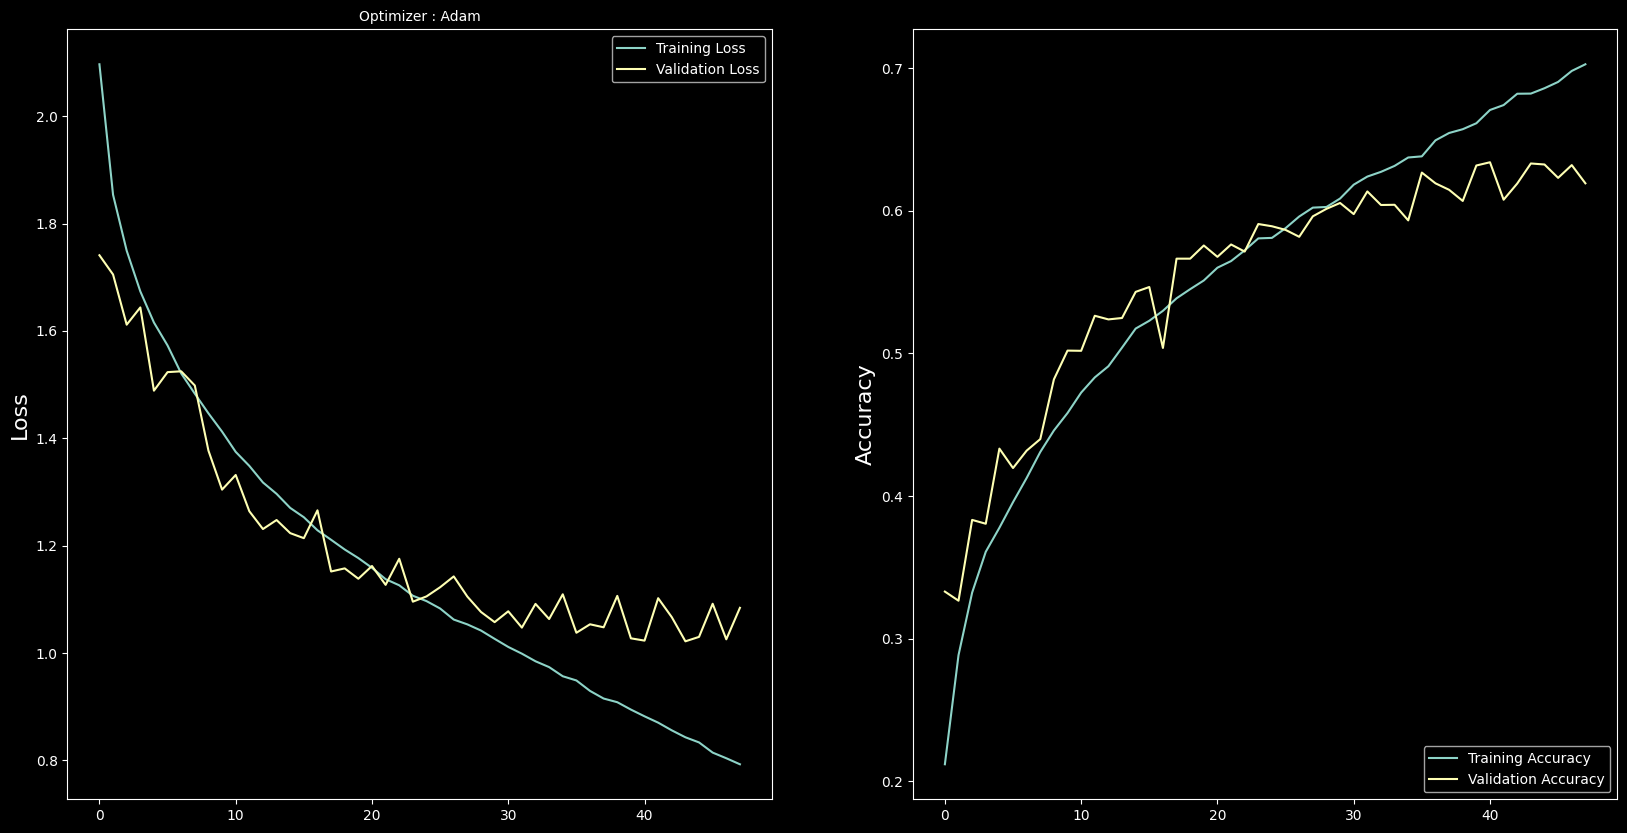

In [ ]:
## Visualiserar tränings- och valideringsförlust samt noggrannhet för att bedöma modellens prestanda och avgöra om ytterligare träning behövs

plt.style.use('dark_background')

plt.figure(figsize=(20, 10))

# Plot för tränings- och valideringsförlust
plt.subplot(1, 2, 1)
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# Plot för tränings- och valideringsnoggrannhet
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()